In [112]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from mne.preprocessing import ICA

In [3]:
def SubjFolderSearch(path):
    subjFolders = os.listdir(path)
    AllFolders = []
    for i in subjFolders:
        if '.DS_Store' not in i:
            AllFolders.append(i)
    
    AllFolders_dict = {}
    for eachFolder in AllFolders:
        eachFolderPath = os.path.join(path,eachFolder)
        folderContents = os.listdir(eachFolderPath)
        AllFolders_dict[eachFolder] = [file for file in folderContents if '.set' in file]
       
        
    return AllFolders_dict

In [4]:
#seach all folders and the set files in each folder
path = '/Volumes/flash32/EEGLAB'
AllSetFiles = SubjFolderSearch(path)
print(AllSetFiles)

{'SA20140304': ['20140304_1418.set', '20140304_1614.set'], 'SA20140306': ['20140306_1133.set', '20140306_1338.set']}


In [90]:
# read file
np.random.seed(42)
folder_keys = list(AllSetFiles.keys())      
folder = os.path.join(path,folder_keys[1])

set_file = os.path.join(folder, AllSetFiles[folder_keys[1]][1])
raw = mne.io.read_raw_eeglab(set_file, preload=True, verbose = True)
raw_copy = raw.copy().crop(10,300)

Reading /Volumes/flash32/EEGLAB/SA20140306/20140306_1338.fdt
Reading 0 ... 796266  =      0.000 ...  1555.207 secs...


In [92]:
events = mne.find_events(raw_copy,min_duration=1/raw.info['sfreq'], shortest_event=1)

1072 events found
Event IDs: [  1   2   3   4   5   7   8   9  10  11  13  14  19  20  21  31 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 157 158 159
 160 161 162 163 164]


In [93]:
event_id = {'TRIALSTART':31,
            'LEFTBUTTON':131, # only one button code is sent,
            'RIGHTBUTTON':132, # but it may appear before f2 stim if fast response
            'CONGRUENT':133,# only one congruity code is sent
            'INCONGRUENT':134,
            'CORRECT':129, # only one accuracy code is sent
            #'INCORRECT':130,
            #target
            'BABY_T':135, 
            'BELL_T':136,
            'BIRD_T':137, 
            'BURP_T':138, 
            'DOG_T':139, 
            'DRUM_T':140, 
            'KNOCK_T':141, 
            'LAUGH_T':142, 
            'PHONE_T':143, 
            'TRAIN_T':144,  
            'WATER_T':145,
            #flanker
            #'BABY_F':155, 
            #'BELL_F':156,
            'BIRD_F':157, 
            'BURP_F':158, 
            'DOG_F':159, 
            'DRUM_F':160, 
            'KNOCK_F':161, 
            'LAUGH_F':162, 
            'PHONE_F':163, 
            'TRAIN_F':164,  
            #'WATER_F':165,
            }

In [94]:
raw_copy.filter(1., None, n_jobs=1, fir_design='firwin')
epoch = mne.Epochs(raw_copy,events,event_id=event_id,preload=True)

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1691 samples (3.303 sec) selected
710 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 710 events and 359 original time points ...
3 bad epochs dropped


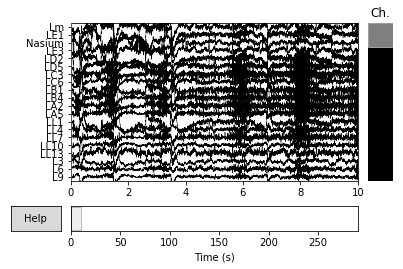

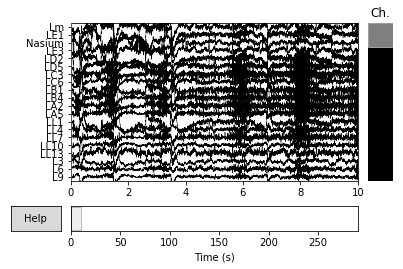

In [96]:
raw_copy.plot()

In [97]:
picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')

In [117]:
method = 'infomax'

# Choose other parameters
n_pca_components = 5  # if float, select n_components by explained variance of PCA
max_pca_components = 5
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23

In [118]:
ica = ICA(n_pca_components=n_pca_components,max_pca_components=max_pca_components, method=method, random_state=random_state)
print(ica)

<ICA  |  no decomposition, fit (infomax):  samples, no dimension reduction>


In [119]:
ica.fit(epoch,picks=picks_eeg,decim=decim)
print(ica)

Fitting ICA to data using 128 channels (please be patient, this may take a while)
Using all PCA components: 5
 


/anaconda3/lib/python3.6/site-packages/mne/preprocessing/infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Fitting ICA took 21.9s.
<ICA  |  epochs decomposition, fit (infomax): 84840 samples, 5 components, channels used: "eeg">


Transforming to ICA space (5 components)
Zeroing out 0 ICA components


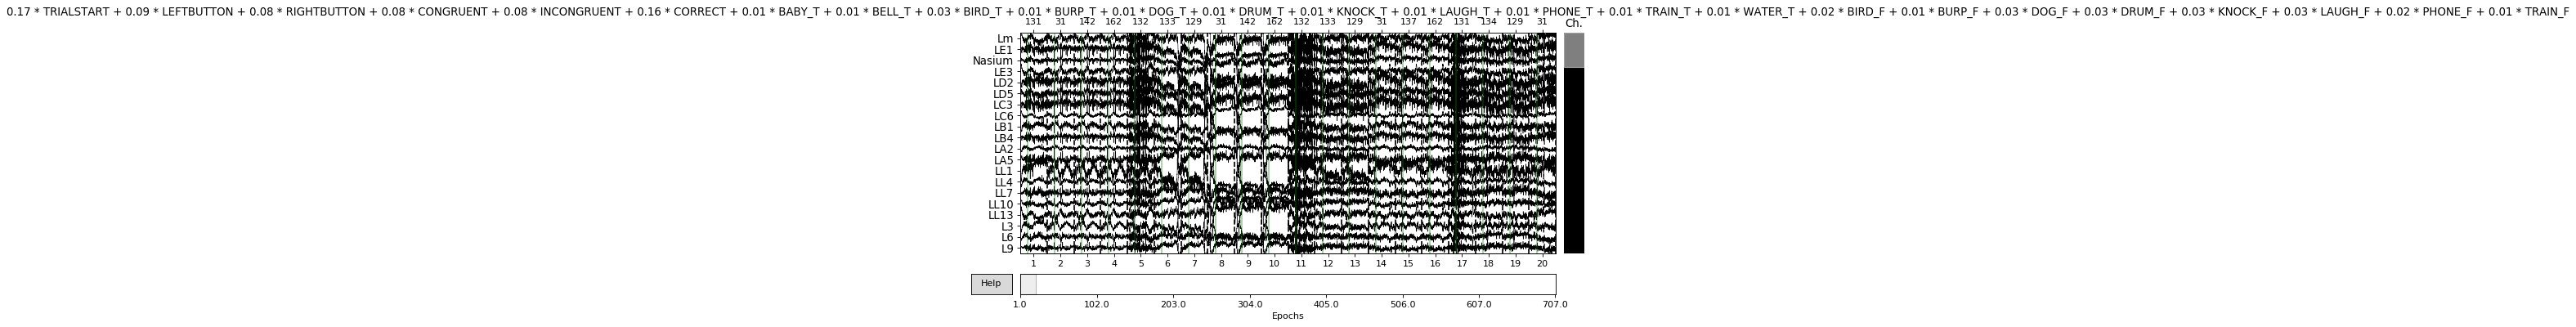

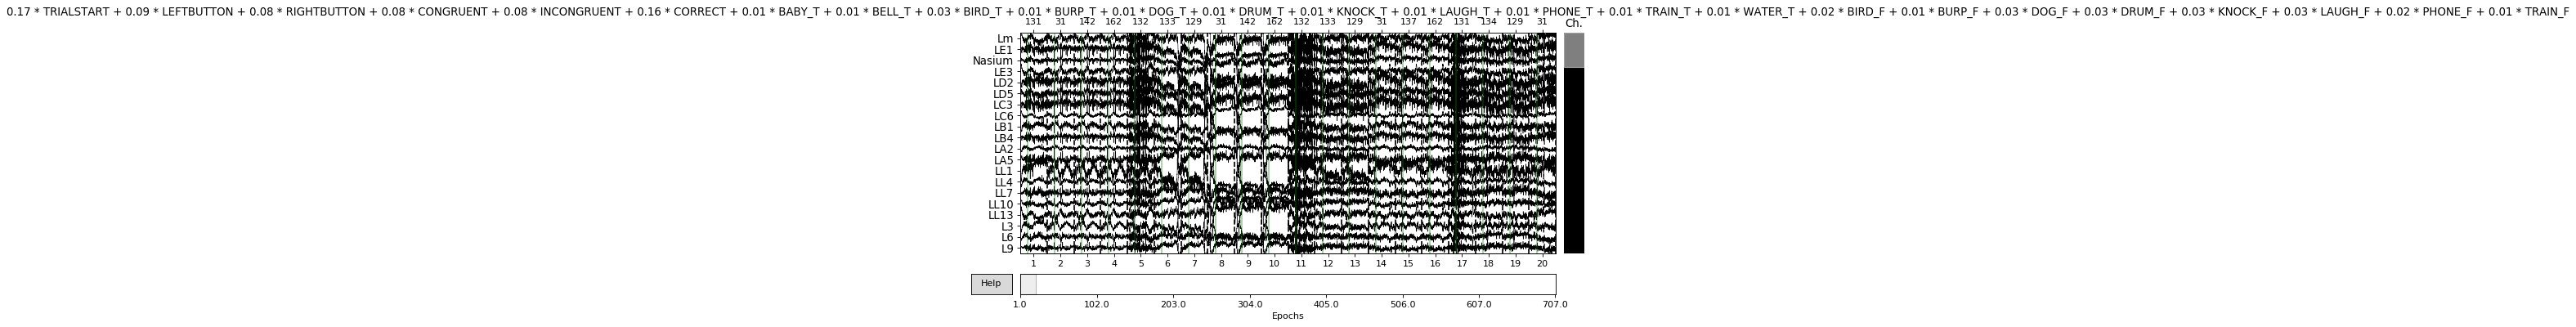

In [120]:
ica.apply(epoch)
epoch.plot()

In [105]:
X=epoch.get_data()
pca = UnsupervisedSpatialFilter(PCA(10), average=False)
pca_data = pca.fit_transform(X)

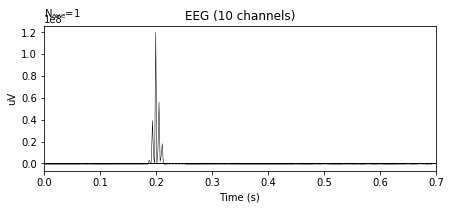

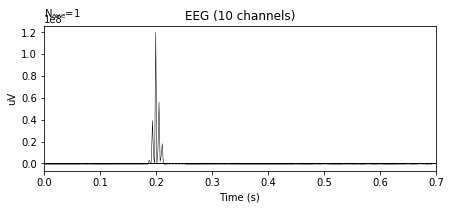

In [103]:
pca = UnsupervisedSpatialFilter(PCA(10), average=False)
pca_data = pca.fit_transform(X)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(10, epoch.info['sfreq'],
                                     ch_types='eeg'))
ev.plot(show=False, window_title="PCA", time_unit='s')

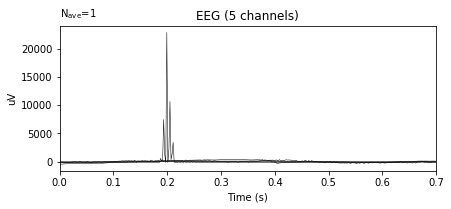

In [116]:
ica = UnsupervisedSpatialFilter(FastICA(5), average=False)
ica_data = ica.fit_transform(X)
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(5, epoch.info['sfreq'],
                                      ch_types='eeg'))
ev1.plot(show=False, window_title='ICA', time_unit='s')

plt.show()